In [1]:
%load_ext autoreload
%autoreload
from trafpy_vectorised_packer.plotting import PlotAesthetics
from trafpy_vectorised_packer.utils import load_ramp_cluster_environment_metrics_from_wandb_sweep

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

from omegaconf import OmegaConf
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

In [5]:
%autoreload

num_eps = []
for stage in range(2):
    for eps in [8, 16, 32, 64, 128, 256, 512, 1024]:
        for seed in range(4):
            num_eps.append(eps)
        
stage_1_times = [32.5, 30.725, 28.626, 28.731, 37.243, 30.538, 29.890, 28.67, 38.3, 37.038, 29.233, 29.062, 30.290, 31.280, 29.175, 33.202, 29.507, 28.317, 31.861, 29.829, 32.689, 32.578, 30.266, 32.410, 34.406, 32.334, 33.480, 36.279, 34.406, 32.334, 33.480, 36.279]
stage_2_times = [0.136, 0.151, 0.139, 0.141, 0.5, 0.521, 0.538, 0.478, 6.976, 6.105, 6.176, 6.188, 89.604, 90.621, 82.876, 91.143, 1425.91, 1607.499, 1548.747, 1417.870, 31931.326, 28321.759, 27519.141, 27830.886, 650000, 650000, 650000, 650000, 15280000, 15280000, 15280000, 15280000]
time = stage_1_times + stage_2_times

stage_type = ['Stage One\n(Sampling)' for _ in range(len(stage_1_times))]
stage_type.extend(['Stage Two\n(Original Packing)' for _ in range(len(stage_2_times))])

eps_to_times_dict = {
    'num_eps': num_eps,
    'time_s': time,
    'Stage': stage_type,
}

print(f'\nEpisode stats:')
for key, val in eps_to_times_dict.items():
    print(f'key {key} -> {len(val)} vals')
eps_to_times_df = pd.DataFrame(eps_to_times_dict)
display(eps_to_times_df)




Episode stats:
key num_eps -> 64 vals
key time_s -> 64 vals
key Stage -> 64 vals


,num_eps,time_s,Stage
0,8,3.250000e+01,Stage One\n(Sampling)
1,8,3.072500e+01,Stage One\n(Sampling)
2,8,2.862600e+01,Stage One\n(Sampling)
3,8,2.873100e+01,Stage One\n(Sampling)
4,16,3.724300e+01,Stage One\n(Sampling)
...,...,...,...
59,512,6.500000e+05,Stage Two\n(Original Packing)
60,1024,1.528000e+07,Stage Two\n(Original Packing)
61,1024,1.528000e+07,Stage Two\n(Original Packing)
62,1024,1.528000e+07,Stage Two\n(Original Packing)


In [11]:
def barplot(df, metric):
    aesthetics = PlotAesthetics()
    aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

    estimator = np.mean # np.mean np.median

    scaling_factor = 0.75
    width_scaling_factor = 1
    height_scaling_factor = 1

    # xaxis = episode_stats_df['run_time']
    # xaxis = episode_stats_df['Distribution']
    xaxis = 'num_eps'
    xaxis_label = '\# Network Nodes $|N|$'

    # stat = 'count'
    # stat = 'percent'
    # stat = 'probability'

    metric_to_yaxis_label = {
        'time_s': 'Time (Hours)', # will convert time units automatically ['Seconds', 'Minutes', 'Hours', 'Days']
    }

    hue = 'Stage'

    legend = 'auto'
    # legend = None

    orient = 'v'
    # orient = 'h'

    ylim = None
    # ylim = [20, 100]

    yaxis_label_style = 'plain' # sci plain

    ylog = True
    # ylog = False
    
    normalise_y_vals = False
    # normalise_y_vals = True
    
    # ci = 95
    ci = None
    
    capsize = 0.1
    
    errwidth = 0.5
    
    # palette = aesthetics.palette
    palette = 'pastel'
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    
    
    
    if 'Time' in metric_to_yaxis_label[metric]:
        units = metric_to_yaxis_label[metric].split('(')[-1].split(')')[0]
        _yaxis = np.array(df[metric])
        if units == 'Seconds':
            yaxis = _yaxis
        elif units == 'Minutes':
            yaxis = _yaxis / 60
        elif units == 'Hours':
            yaxis = _yaxis / 60
            yaxis /= 60
        elif units == 'Days':
            yaxis = _yaxis / 60
            yaxis /= 60
            yaxis /= 24
        else:
            raise Exception(f'Unrecognised Time yaxis label units {units}')
    else:
        yaxis = metric
    
    
    
    
    
    
    yaxis_label = metric_to_yaxis_label[metric]
    if orient == 'h':
        orig_xaxis = copy.copy(xaxis)
        orig_metric = copy.copy(metric)
        orig_xaxis_label = copy.copy(xaxis_label)
        orig_yaxis_label = copy.copy(yaxis_label)
        
        xaxis = orig_metric
        xaxis_label = orig_yaxis_label
        metric = orig_xaxis
        yaxis_label = orig_xaxis_label
        
    if normalise_y_vals:
        plot_df = copy.deepcopy(df)
        max_y_val = np.max(plot_df[metric])
        plot_df[metric] /= max_y_val
        yaxis_label += '\n(Normalised)'
    else:
        plot_df = df
    
    g = sns.barplot(data=plot_df, 
                     x=xaxis, 
                     y=yaxis, 
                     hue=hue, 
                     orient=orient,
                     palette=palette,
                     ci=ci,
                     # capsize=capsize,
                     # errwidth=errwidth,
                     # legend=legend,
                     estimator=estimator,
                    )
    
    if legend is not None:
        # ax.legend(labels=context_to_dist.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, labelspacing=0.1, columnspacing=3, prop={'size': 4})
        # sns.move_legend(ax, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, labelspacing=0.1, columnspacing=1, prop={'size': 5.5}, title=None, frameon=False)
        sns.move_legend(ax, 
                        loc='upper center', 
                        bbox_to_anchor=(0.6, 1.3), 
                        ncol=4, 
                        labelspacing=0.5, 
                        columnspacing=1, 
                        prop={'size': 9}, 
                        title=None, 
                        frameon=False)
    # leg = ax.legend()
    # leg.set_multialignment('center')

    if ylim is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])
    g.set_xlabel(xaxis_label)
    g.set_ylabel(yaxis_label)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    # g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    if ylog:
        g.set(yscale='log')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

Plotting metric time_s -> min=0.136 | max=15280000.0 | mean=997547.037328125


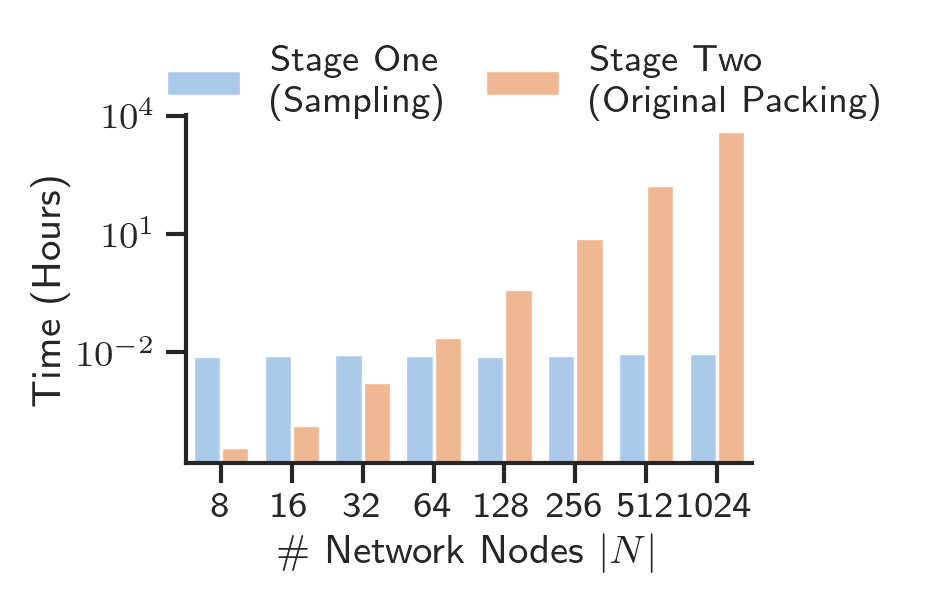

In [12]:
%autoreload

metrics = ['time_s']
for metric in metrics:
    barplot(df=eps_to_times_df, metric=metric)